In [ ]:
import glob
import random
import os
import re

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

# DATA_DIR = '/fast_storage/intern/data/instruction_tuning/fastmri_acceleration_mat_t1'
DATA_DIRS = [
    '/fast_storage/intern/data/instruction_tuning/fastmri_acceleration_mat_t1/train',
    '/fast_storage/intern/data/instruction_tuning/fastmri_crossmodal_mat_t1tot2/train',
]
# DATA_DIR = './brats_segmentation_mat'
# DATA_DIR = './brats_crossmodal_mat'
# DATA_DIR = './brats_denoise_mat'
SEED = 42


In [36]:
random.seed(SEED)

# Parse filename to extract case_id and slice_idx
def parse_filename(filename):
    """Extract case_id and slice_idx from filename.
    Examples:
    - fastmri_123_t1_r4_s001_n00001.mat -> (123, 1)
    - fastmri_456_t1_to_t2_s010_n00005.mat -> (456, 10)
    """
    # Pattern: fastmri_{case_id}_...s{slice}_n{idx}.mat
    match = re.search(r'fastmri_(\d+)_.*_s(\d+)_n\d+\.mat', filename)
    if match:
        case_id = match.group(1)
        slice_idx = int(match.group(2))
        return (case_id, slice_idx)
    return None

# Collect files from all directories
all_files_by_dir = {}
files_by_key = {}  # key = (case_id, slice_idx)

for data_dir in DATA_DIRS:
    files = sorted(glob.glob(f'{data_dir}/*.mat'))
    if not files:
        print(f'Warning: No .mat files found under {data_dir}')
        continue
    all_files_by_dir[data_dir] = files
    print(f'Found {len(files)} .mat files in {os.path.basename(data_dir)}')
    
    # Build index by (case_id, slice_idx)
    for fpath in files:
        fname = os.path.basename(fpath)
        key = parse_filename(fname)
        if key:
            if key not in files_by_key:
                files_by_key[key] = {}
            files_by_key[key][data_dir] = fpath

# Find keys that exist in all directories
common_keys = []
for key, paths_dict in files_by_key.items():
    if len(paths_dict) == len(DATA_DIRS):
        common_keys.append(key)

print(f'\nFound {len(common_keys)} common (case_id, slice) pairs across all directories')

if common_keys:
    # Pick a random common key
    selected_key = random.choice(sorted(common_keys))
    case_id, slice_idx = selected_key
    print(f'Selected sample: case_id={case_id}, slice={slice_idx}')
    
    # Get paths for this key
    sample_paths = files_by_key[selected_key]
    
    # Check keys in one sample
    first_path = list(sample_paths.values())[0]
    print(f"\nKeys in sample: {list(loadmat(first_path).keys())}")
    
    # Print filenames
    for data_dir, path in sample_paths.items():
        print(f'{os.path.basename(data_dir)}: {os.path.basename(path)}')


Found 13298 .mat files in fastmri_acceleration_mat_t1
Found 17976 .mat files in fastmri_crossmodal_mat_t1tot2

Found 13298 common (case_id, slice) pairs across all directories
Selected sample: case_id=529603138094, slice=7

Keys in sample: ['__header__', '__version__', '__globals__', 'image', 'label', 'instruction', 'text', 'image_header']
fastmri_acceleration_mat_t1: fastmri_529603138094_t1_r6_s007_n03105.mat
fastmri_crossmodal_mat_t1tot2: fastmri_529603138094_t1_to_t2_s007_n03105.mat


In [32]:
def load_data(sample_path):
    data = loadmat(sample_path)
    image = data['image']
    label = data['label']
    text = data['text']
    instruction = data['instruction']

    # Handle MATLAB string formats
    if isinstance(text, np.ndarray):
        text = text.squeeze()
        if text.dtype.kind in {'U', 'S'}:
            text = str(text)
        elif text.dtype == object:
            text = str(text.tolist())

    print('Instruction:', instruction)
    print('Metadata:', text)
    print('Image shape:', image.shape, 'Label shape:', label.shape)
    return image, label


In [33]:
def visualize_seg(image, label):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap='viridis')
    plt.title('Label')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    plt.imshow(label, cmap='viridis', alpha=0.4)
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_crossmodal(image, label):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray')
    plt.title('Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Instruction: [[array(['Reconstruct this T1 image (R=6).'], dtype='<U32')]]
Metadata: ["<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'\nsizeof_hdr      : 348\ndata_type       : b''\ndb_name         : b''\nextents         : 0\nsession_error   : 0\nregular         : b'r'\ndim_info        : 54\ndim             : [  3 320 320  16   1   1   1   1]\nintent_p1       : 0.0\nintent_p2       : 0.0\nintent_p3       : 0.0\nintent_code     : none\ndatatype        : int16\nbitpix          : 16\nslice_start     : 0\npixdim          : [1.         0.6875     0.68749994 5.000001   0.25       0.\n 0.         0.        ]\nvox_offset      : 0.0\nscl_slope       : nan\nscl_inter       : nan\nslice_end       : 0\nslice_code      : unknown\nxyzt_units      : 10\ncal_max         : 0.0\ncal_min         : 0.0\nslice_duration  : 0.0\ntoffset         : 0.0\nglmax           : 0\nglmin           : 0\ndescrip         : b'TE=2.5;Time=0.000;mb=16'\naux_file        : b''\nqform_code      : unknown\nsform_code  

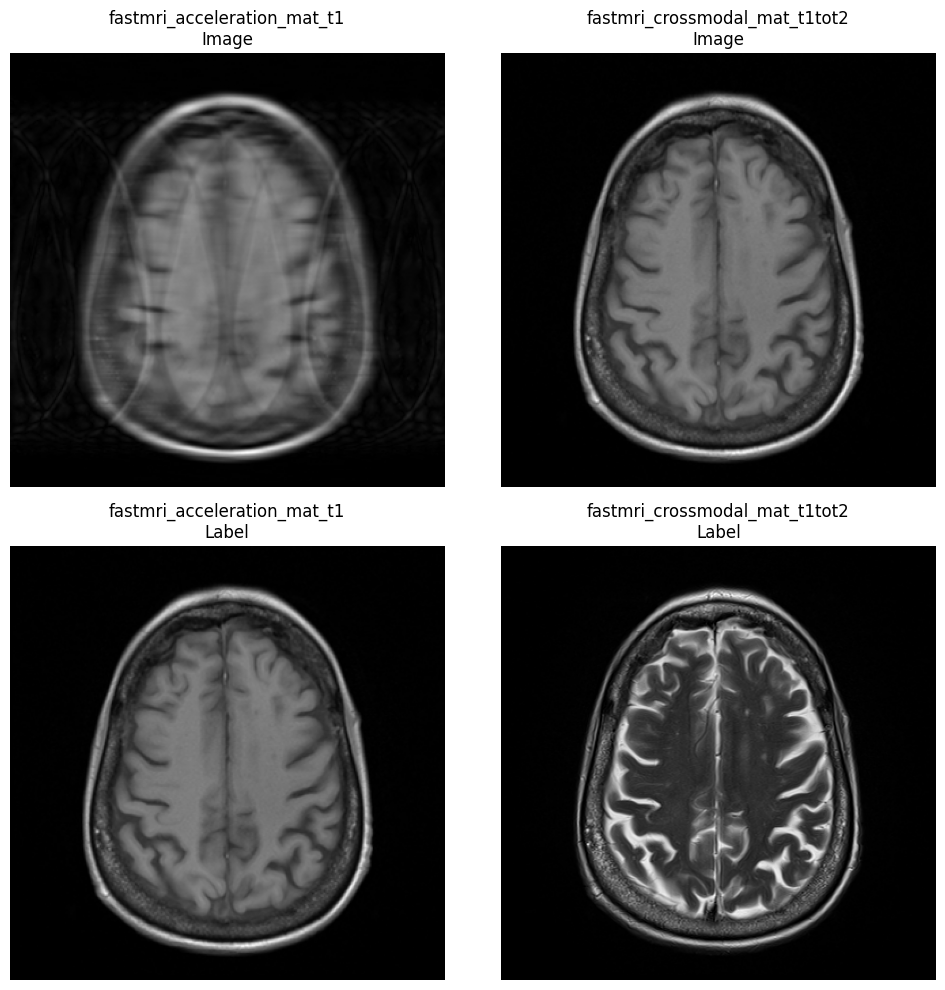

In [35]:
# Visualize the same slice across all directories
num_dirs = len(sample_paths)
fig, axes = plt.subplots(2, num_dirs, figsize=(5 * num_dirs, 10))

if num_dirs == 1:
    axes = axes.reshape(2, 1)

for idx, (data_dir, sample_path) in enumerate(sample_paths.items()):
    image, label = load_data(sample_path)
    dir_name = os.path.basename(data_dir)
    
    # Plot image
    axes[0, idx].imshow(image, cmap='gray')
    axes[0, idx].set_title(f'{dir_name}\nImage')
    axes[0, idx].axis('off')
    
    # Plot label
    axes[1, idx].imshow(label, cmap='gray')
    axes[1, idx].set_title(f'{dir_name}\nLabel')
    axes[1, idx].axis('off')
    
    print(f'{dir_name}: image range [{image.min():.4f}, {image.max():.4f}], label range [{label.min():.4f}, {label.max():.4f}]')

plt.tight_layout()
plt.show()


In [13]:
# calculate SNR
signal_mask = image > 0.05 * np.max(image)
signal_level = image[signal_mask].mean()
noise_level = np.std(image[~signal_mask])
snr = signal_level / noise_level
print(f'Signal level: {signal_level:.4f}, Noise level: {noise_level:.4f}, SNR: {snr:.2f}')

Signal level: 420.5384, Noise level: 0.0000, SNR: inf


/tmp/ipykernel_1379969/405242539.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  snr = signal_level / noise_level


In [14]:
print(label.min(), label.max())

0.0 921.0
